In [1]:
import ROOT

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tqdm import tqdm

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

Welcome to JupyROOT 6.20/08


0

In [2]:
def selection_cut_SR(tree):
    # compute the cutflow numbers after each cut and evaluate |Delta eta_ll|, Delta phi_jj, mT 
    # A. Leptons cut
    # B. MET cut
    # C. Jets cut

    n_event_count = 0
    lepton_cut_count = 0
    met_cut_count = 0
    jet_cut_count = 0

    deta_ll, dphi_jj, mT = [], [], []

    for event_id, event in tqdm(enumerate(tree)):

        n_event_count += 1

        # --- A. 輕子篩選 (Leptons) ---
        leptons = []
        # 讀取電子
        for e in event.Electron:
            if e.PT > 27.0 and abs(e.Eta) < 2.47:
                if 1.37 < abs(e.Eta) < 1.52:  # 電子過渡區
                    continue
                vec = ROOT.TLorentzVector()
                vec.SetPtEtaPhiM(e.PT, e.Eta, e.Phi, 0.000511)
                leptons.append({'p4': vec, 'charge': e.Charge, 'flavor': 'e'})
        # 讀取緲子
        for m in event.Muon:
            if m.PT > 27.0 and abs(m.Eta) < 2.5:
                vec = ROOT.TLorentzVector()
                vec.SetPtEtaPhiM(m.PT, m.Eta, m.Phi, 0.10566)
                leptons.append({'p4': vec, 'charge': m.Charge, 'flavor': 'mu'})
        
        # 依照 pT 排序
        leptons.sort(key=lambda x: x['p4'].Pt(), reverse=True)

        # 必須至少有兩個輕子
        if len(leptons) < 2:
            continue
        
        l1, l2 = leptons[0], leptons[1]
        
        # 必須是同號電荷 (Same-sign)
        if l1['charge'] != l2['charge']:
            continue
        
        # 雙輕子不變質量 > 20 GeV
        ll_p4 = l1['p4'] + l2['p4']
        if ll_p4.M() <= 20.0:
            continue

        lepton_cut_count += 1

        # --- B. 遺失橫向動量 (MET) ---
        met = event.MissingET[0]
        if met.MET <= 30.0:
            continue

        met_cut_count += 1

        # --- C. 噴流篩選 (Jets) ---
        jets = []
        for j in event.Jet:
            if abs(j.Eta) < 4.5 and j.PT > 35.0:
                vec = ROOT.TLorentzVector()
                vec.SetPtEtaPhiM(j.PT, j.Eta, j.Phi, j.Mass)
                jets.append(vec)
                
        jets.sort(key=lambda x: x.Pt(), reverse=True)

        # 至少需要兩顆噴流，且領頭噴流 pT > 65 GeV
        if len(jets) < 2:
            continue

        if jets[0].Pt() <= 65.0:
            continue
        
        j1, j2 = jets[0], jets[1]

        # VBS 拓撲: m_jj > 500 GeV, |Delta y_jj| > 2.0
        # 這裡使用 Rapidity() 計算精確的 y，而非 eta
        if (j1 + j2).M() <= 500.0:
            continue
        if abs(j1.Rapidity() - j2.Rapidity()) <= 2.0:
            continue

        jet_cut_count += 1


        # |Delta eta_ll|
        deta_ll.append(abs(l1['p4'].Eta() - l2['p4'].Eta()))

        # Delta phi_jj (使用 TLorentzVector 內建的 DeltaPhi 處理週期性)
        dphi_jj.append(abs(j1.DeltaPhi(j2)))

        # mT (雙輕子系統與 MET 構成的橫向質量)
        met_px = met.MET * np.cos(met.Phi)
        met_py = met.MET * np.sin(met.Phi)
        
        Et_ll = np.sqrt(ll_p4.Pt()**2 + ll_p4.M()**2)
        px_tot = ll_p4.Px() + met_px
        py_tot = ll_p4.Py() + met_py
        
        # mT^2 = (Et_ll + MET)^2 - (px_tot^2 + py_tot^2)
        mT_sq = (Et_ll + met.MET)**2 - (px_tot**2 + py_tot**2)
        mT.append(np.sqrt(mT_sq) if mT_sq > 0 else 0)

    cutflow_number = {
        'Total': n_event_count,
        'lepton cut': lepton_cut_count,
        'met cut': met_cut_count,
        'jet cut': jet_cut_count,
    }

    deta_ll = np.array(deta_ll)
    dphi_jj = np.array(dphi_jj)
    mT = np.array(mT)

    results = {
        'cutflow number': cutflow_number,
        'deta_ll': deta_ll,
        'dphi_jj': dphi_jj,
        'mT': mT,
    }

    return results

In [3]:
root_file = './EW_WWjj_LL/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_LL = selection_cut_SR(tree)

root_file = './EW_WWjj_LT/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_LT = selection_cut_SR(tree)

root_file = './EW_WWjj_TT/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_TT = selection_cut_SR(tree)

100000it [01:37, 1028.36it/s]
100000it [02:47, 596.40it/s]
100000it [03:01, 549.69it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class Track read from file ./EW_WWjj_LL/Events/run_02/tag_1_delphes_events.root
   has the same version (=3) as the active class but a different checksum.
   You should update the version to ClassDef(Track,4).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float C; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float Mass; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:

In [4]:
np.save('./selection_results_EW_WWjj_LL.npy', results_LL)
np.save('./selection_results_EW_WWjj_LT.npy', results_LT)
np.save('./selection_results_EW_WWjj_TT.npy', results_TT)

In [5]:
LL_selection = np.load('./selection_results_EW_WWjj_LL.npy', allow_pickle=True).item()
LT_selection = np.load('./selection_results_EW_WWjj_LT.npy', allow_pickle=True).item()
TT_selection = np.load('./selection_results_EW_WWjj_TT.npy', allow_pickle=True).item()

In [6]:
print('LL mode')
n_total = LL_selection['cutflow number']['Total']
for key, value in LL_selection['cutflow number'].items():
    print(f'{key:20} {value:<8} & {value/n_total:8.2f}')

print('LT mode')
n_total = LT_selection['cutflow number']['Total']
for key, value in LT_selection['cutflow number'].items():
    print(f'{key:20} {value:<8} & {value/n_total:8.2f}')

print('TT mode')
n_total = TT_selection['cutflow number']['Total']
for key, value in TT_selection['cutflow number'].items():
    print(f'{key:20} {value:<8} & {value/n_total:8.2f}')

LL mode
Total                100000   &     1.00
lepton cut           26777    &     0.27
met cut              24781    &     0.25
jet cut              20005    &     0.20
LT mode
Total                100000   &     1.00
lepton cut           27270    &     0.27
met cut              25518    &     0.26
jet cut              21087    &     0.21
TT mode
Total                100000   &     1.00
lepton cut           29825    &     0.30
met cut              28323    &     0.28
jet cut              23298    &     0.23


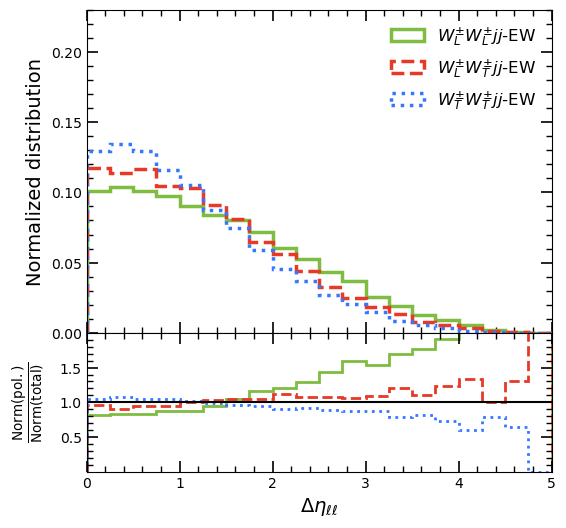

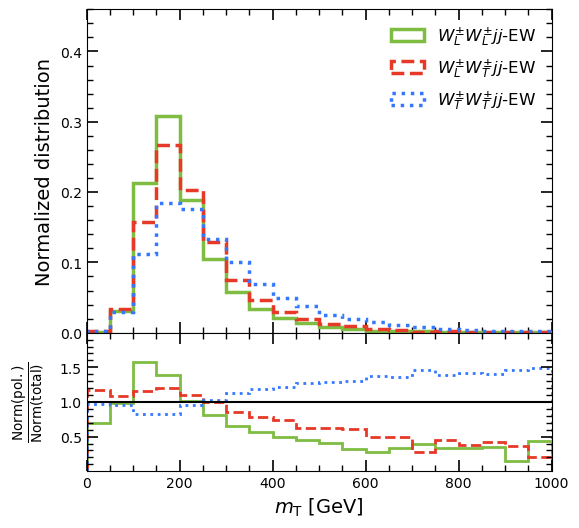

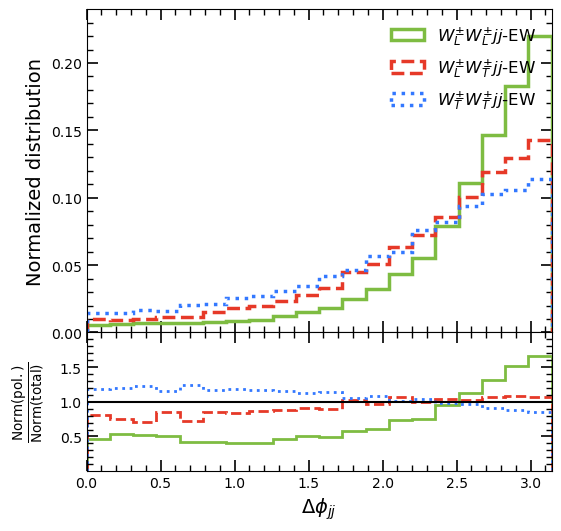

In [7]:
# ==========================================
# 1. 定義繪圖函數 (處理主圖與比例圖)
# ==========================================
def plot_atlas_variable(ax_main, ax_ratio, data_dict, var_key, bins, val_range, xlabel, ymax):
    
    # 提取三個極化態的資料
    LL_data = data_dict['LL'][var_key]
    LT_data = data_dict['LT'][var_key]
    TT_data = data_dict['TT'][var_key]
    
    # 計算 Histogram 數值 (使用 weights 正規化使得面積/總和 = 1)
    hist_LL, bin_edges = np.histogram(LL_data, bins=bins, range=val_range, weights=np.ones_like(LL_data)/len(LL_data))
    hist_LT, _ = np.histogram(LT_data, bins=bins, range=val_range, weights=np.ones_like(LT_data)/len(LT_data))
    hist_TT, _ = np.histogram(TT_data, bins=bins, range=val_range, weights=np.ones_like(TT_data)/len(TT_data))
    
    # 設定繪圖樣式 (對標 ATLAS 論文的配色與線型)
    styles = {
        'LL': {"color": "#7EBC42", "linestyle": "solid", "label": '$W_L^{\pm}W_L^{\pm}jj$-EW'}, # 亮綠色
        'LT': {"color": "#E63928", "linestyle": "dashed", "label": '$W_L^{\pm}W_T^{\pm}jj$-EW'}, # 紅色虛線
        'TT': {"color": "#3378FF", "linestyle": "dotted", "label": '$W_T^{\pm}W_T^{\pm}jj$-EW'}  # 藍色點線
    }
    
    # --- 繪製上層 Main Pad ---
    # matplotlib 的 step 預設從 bin 的左邊緣開始畫，為了讓最右邊閉合，需要在最後補一個數值
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax_main.hist(bin_centers, bins=bin_edges, weights=hist_LL, histtype='step', linewidth=2.5, **styles['LL'])
    ax_main.hist(bin_centers, bins=bin_edges, weights=hist_LT, histtype='step', linewidth=2.5, **styles['LT'])
    ax_main.hist(bin_centers, bins=bin_edges, weights=hist_TT, histtype='step', linewidth=2.5, **styles['TT'])
    
    ax_main.set_xlim(val_range)
    ax_main.set_ylim(0, ymax)
    ax_main.set_ylabel("Normalized distribution", fontsize=14)
    ax_main.tick_params(axis='x', labelbottom=False) # 隱藏 X 軸刻度文字
    
    # 設定刻度向內並啟用小刻度
    ax_main.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, top=True, right=True)
    ax_main.tick_params(axis='both', which='minor', direction='in', length=4, width=1.0, top=True, right=True)
    ax_main.minorticks_on()
    
    # 設定圖例
    ax_main.legend(frameon=False, loc="upper right", fontsize=12)
    
    # --- 計算並繪製下層 Ratio Pad ---
    # 合成 Total SM 形狀 (10% LL + 30% LT + 60% TT)
    hist_total = 0.10 * hist_LL + 0.30 * hist_LT + 0.60 * hist_TT
    
    # 避免除以零
    safe_total = np.where(hist_total == 0, 1e-10, hist_total)
    
    ratio_LL = hist_LL / safe_total
    ratio_LT = hist_LT / safe_total
    ratio_TT = hist_TT / safe_total
    
    # 用 step 畫出 Ratio
    ax_ratio.stairs(ratio_LL, edges=bin_edges, color=styles['LL']["color"], linewidth=2, linestyle=styles['LL']["linestyle"])
    ax_ratio.stairs(ratio_LT, edges=bin_edges, color=styles['LT']["color"], linewidth=2, linestyle=styles['LT']["linestyle"])
    ax_ratio.stairs(ratio_TT, edges=bin_edges, color=styles['TT']["color"], linewidth=2, linestyle=styles['TT']["linestyle"])
    
    # 畫出 y=1 的參考實線
    ax_ratio.axhline(1.0, color='black', linewidth=1.5)
    
    ax_ratio.set_xlim(val_range)
    ax_ratio.set_ylim(0, 2.0)
    ax_ratio.set_xlabel(xlabel, fontsize=14)
    ax_ratio.set_ylabel(r"$\frac{\mathrm{Norm(pol.)}}{\mathrm{Norm(total)}}$", fontsize=14, labelpad=10)
    
    # 調整 Y 軸刻度數量避免太擠
    ax_ratio.set_yticks([0.5, 1.0, 1.5])
    
    # 設定刻度向內並啟用小刻度
    ax_ratio.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, top=True, right=True)
    ax_ratio.tick_params(axis='both', which='minor', direction='in', length=4, width=1.0, top=True, right=True)
    ax_ratio.minorticks_on()


# ==========================================
# 2. 準備你的資料 (請將這裡替換成你真實的 numpy 陣列)
# ==========================================

my_data = {
    'LL': LL_selection,
    'LT': LT_selection,
    'TT': TT_selection
}

# ==========================================
# 3. 分別繪製並儲存三張獨立的圖
# ==========================================

variables = [
    {'key': "deta_ll", 'bins': 20, "range": (0, 5.0), 'xlabel': '$\Delta\eta_{\ell\ell}$', 'ymax': 0.23, 'filename': 'deta_ll'},
    {'key': "mT",      'bins': 20, "range": (0, 1000), 'xlabel': '$m_\mathrm{T}$ [GeV]', 'ymax': 0.46, 'filename': 'mT'},
    {'key': "dphi_jj", 'bins': 20, "range": (0, np.pi), 'xlabel': '$\Delta\phi_{jj}$', 'ymax': 0.24, 'filename': 'dphi_jj'}
]

for var_info in variables:
    # 為每個變量創建獨立的圖
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[7, 3], hspace=0.00)
    
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1])
    
    plot_atlas_variable(
        ax_main=ax_main, 
        ax_ratio=ax_ratio, 
        data_dict=my_data, 
        var_key=var_info['key'], 
        bins=var_info['bins'], 
        val_range=var_info["range"], 
        xlabel=var_info['xlabel'], 
        ymax=var_info['ymax']
    )
    
    # 儲存圖片
    plt.savefig(f"../figures/EW_WWjj_{var_info['filename']}.pdf", bbox_inches='tight', dpi=300)
    
    plt.show()
    plt.close()